### Imports

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import to_categorical as make_class_categorical
import _pickle as pickle
from tqdm import tqdm
import pdb

Using TensorFlow backend.


### Assignment 2 functions

#### Initialize weights

In [11]:
def initialize_weights(d, m, K, std=0.001):
    """
    Initializes the weight and bias arrays for the 2 layers of the network

    :param d: Dimensionality of the input data
    :param m: Number of nodes in the first layer
    :param K: Number of different classes (K=10 for the CIFAR-10 dataset)
    :param variance (optional): The variance of the normal distribution that will be used for the initialization of the weights

    :return: Weights and bias arrays for the first and second layer of the neural network
    """

    np.random.seed(400)

    W1 = np.random.normal(0, std, size=(m, d))
    b1 = np.zeros(shape=(m, 1))

    W2 = np.random.normal(0, std, size=(K, m))
    b2 = np.zeros(shape=(K, 1))

    return W1, b1, W2, b2

#### Load Batch

In [12]:
def LoadBatch(filename):
    """
    Loads batch based on the given filename and produces the X, Y, and y arrays

    :param filename: Path of the file
    :return: X, Y and y arrays
    """

    # borrowed from https://www.cs.toronto.edu/~kriz/cifar.html
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    dictionary = unpickle(filename)

    # borrowed from https://stackoverflow.com/questions/16977385/extract-the-nth-key-in-a-python-dictionary?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    def ix(dic, n):  # don't use dict as  a variable name
        try:
            return list(dic)[n]  # or sorted(dic)[n] if you want the keys to be sorted
        except IndexError:
            print('not enough keys')

    garbage = ix(dictionary, 1)
    y = dictionary[garbage]
    Y = np.transpose(make_class_categorical(y, 10))
    garbage = ix(dictionary, 2)
    X = np.transpose(dictionary[garbage]) / 255

    return X, Y, y

#### ReLU


In [13]:
def ReLU(x):
    """
    Rectified Linear Unit function

    :param x: Input to the function

    :return: Output of ReLU(x)
    """

    return np.maximum(x, 0)

#### Softmax

In [14]:
def softmax(X, theta=1.0, axis=None):

    # Softmax over numpy rows and columns, taking care for overflow cases
    # Many thanks to https://nolanbconaway.github.io/blog/2017/softmax-numpy
    # Usage: Softmax over rows-> axis =0, softmax over columns ->axis =1

    """
    Compute the softmax of each element along an axis of X.
    Parameters
    ----------
    X: ND-Array. Probably should be floats.
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the
        first non-singleton axis.
    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter,
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis=axis), axis)

    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis=axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

#### Evaluate Classifier

In [15]:
def EvaluateClassifier(X, W1, b1, W2, b2):
    """
    Computes the Softmax output of the 2 layer network, based on input data X and trained weight and bias arrays

    :param X: Input data
    :param W1: Weight array of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight array of the second layer
    :param b2: Bias vector of the second layer

    :return: Softmax output of the trained network
    """
    s1 = np.dot(W1, X) + b1
    h = ReLU(s1)
    s = np.dot(W2, h) + b2
    p = softmax(s, axis=0)

    return p, h, s1

#### Predict classes

In [16]:
def predictClasses(p):
    """
    Predicts classes based on the softmax output of the network

    :param p: Softmax output of the network
    :return: Predicted classes
    """

    return np.argmax(p, axis=0)

#### Compute Accuracy

In [37]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    """
    Computes the accuracy of the feed-forward 2-layer network

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer

    :return: Accuracy metric of the neural network.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)
    predictions = predictClasses(p)

    accuracy = round(np.sum(np.where(predictions - y == 0, 1, 0)) * 100 / len(y), 2)

    return accuracy

#### Compute Cost

In [18]:
def ComputeCost(X, Y, W1, W2, b1, b2, regularization_term= 0):
    """
    Computes the cross-entropy loss on a batch of data.

    :param X: Input data
    :param y: Labels of the ground truth
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param regularization_term: Amount of regularization applied.

    :return: Cross-entropy loss.
    """
    p, _, _ = EvaluateClassifier(X=X, W1=W1, b1=b1, W2=W2, b2=b2)

    cross_entropy_loss = -np.log(np.diag(np.dot(Y.T, p))).sum() / float(X.shape[1])

    weight_sum = np.power(W1, 2).sum() + np.power(W2, 2).sum()

    return cross_entropy_loss + regularization_term * weight_sum

#### Compute Gradients

In [19]:
def ComputeGradsNum(X, Y, W1, b1, W2, b2, regularization_term, h=1e-5):

    """
    Computes gradient descent updates on a batch of data with numerical computations.
    Contributed by Josephine Sullivan for educational purposes for the DD2424 Deep Learning in Data Science course.

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network computed with numerical computations
    """

    grad_W1= np.zeros((W1.shape[0], W1.shape[1]))
    grad_b1= np.zeros((W1.shape[0], 1))
    grad_W2= np.zeros((W2.shape[0], W2.shape[1]))
    grad_b2= np.zeros((W2.shape[0], 1))
    
    c = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2, b2=b2, regularization_term=regularization_term)
    
    for i in range(b1.shape[0]):
        b1_try = np.copy(b1)
        b1_try[i, 0] += h
        c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1_try, W2=W2, b2=b2, regularization_term=regularization_term)
        grad_b1[i,0] = (c2-c) / h

    for i in range(b2.shape[0]):
        b2_try= np.copy(b2)
        b2_try[i, 0] += h
        c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2, b2=b2_try, regularization_term=regularization_term)
        grad_b2[i,0] = (c2-c) / h
        
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            
            W1_try= np.copy(W1)
            W1_try[i,j] += h
            c2= ComputeCost(X=X, Y=Y, W1=W1_try, b1=b1, W2=W2, regularization_term=regularization_term)
            
            grad_W1[i,j] = (c2-c) / h

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = np.copy(W2)
            W2_try[i, j] += h
            c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2_try, regularization_term=regularization_term)

            grad_W2[i, j] = (c2 - c) / h

    return W1, b1, W2, b2

In [20]:
def ComputeGradsNumSlow(X, Y, W1, b1, W2, b2, regularization_term, h=1e-5):
    """
    Computes gradient descent updates on a batch of data with numerical computations of great precision, thus slower computations.
    Contributed by Josephine Sullivan for educational purposes for the DD2424 Deep Learning in Data Science course.

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network computed with numerical computations with high precision.
    """

    grad_W1= np.zeros((W1.shape[0], W1.shape[1]))
    grad_b1= np.zeros((b1.shape[0], 1))
    grad_W2= np.zeros((W2.shape[0], W2.shape[1]))
    grad_b2= np.zeros((b2.shape[0], 1))
    
    for i in tqdm(range(b1.shape[0])):

        b1_try = np.copy(b1)
        b1_try[i,0] -= h
        c1 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1_try, W2=W2, b2=b2, regularization_term=regularization_term)
        b1_try = np.copy(b1)
        b1_try[i,0] += h
        c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1_try, W2=W2, b2=b2, regularization_term=regularization_term)
        grad_b1[i,0] = (c2-c1)/(2*h)

    for i in tqdm(range(b2.shape[0])):
        b2_try = np.copy(b2)
        b2_try[i, 0] -= h
        c1 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2, b2=b2_try, regularization_term=regularization_term)

        b2_try = np.copy(b2)
        b2_try[i, 0] += h
        c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2, b2=b2_try, regularization_term=regularization_term)
        grad_b2[i, 0] = (c2 - c1) / (2 * h)

    for i in tqdm(range(W1.shape[0])):
        for j in tqdm(range(W1.shape[1])):

            W1_try = np.copy(W1)
            W1_try[i, j] -= h
            c1 = ComputeCost(X=X, Y=Y, W1=W1_try, b1=b1, W2=W2, b2=b2, regularization_term=regularization_term)

            W1_try = np.copy(W1)
            W1_try[i, j] += h
            c2 = ComputeCost(X=X, Y=Y, W1=W1_try, b1=b1, W2=W2, b2=b2, regularization_term=regularization_term)

            grad_W1[i, j] = (c2 - c1) / (2 * h)

    for i in tqdm(range(W2.shape[0])):
        for j in tqdm(range(W2.shape[1])):

            W2_try = np.copy(W2)
            W2_try[i, j] -= h
            c1 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2_try, b2=b2, regularization_term=regularization_term)

            W2_try = np.copy(W2)
            W2_try[i, j] += h
            c2 = ComputeCost(X=X, Y=Y, W1=W1, b1=b1, W2=W2_try, b2=b2, regularization_term=regularization_term)

            grad_W2[i, j] = (c2 - c1) / (2 * h)

    return W1, b1, W2, b2

In [21]:
def ComputeGradients(X, Y, W1, b1, W2, b2, p, h, s1, regularization_term= 0):
    """
    Computes gradient descent updates on a batch of data

    :param X: Input data
    :param Y: One-hot representation of the true labels of input data X
    :param W1: Weight matrix of the first layer
    :param b1: Bias vector of the first layer
    :param W2: Weight matrix of the second layer
    :param b2: Bias vector of the second layer
    :param p: Softmax probabilities (predictions) of the network over classes.
    :param h: ReLU activations of the network.
    :param s1: True outout of the first layer of the network.
    :param regularization_term: Contribution of the regularization in the weight updates

    :return: Weight and bias updates of the first and second layer of our network
    """

    # Back-propagate second layer at first

    g = p - Y
    grad_b2 = g.sum(axis=1).reshape(b2.shape)
    grad_W2 = np.dot(g, h.T)

    # Back-propagate the gradient vector g to the first layer
    g = np.dot(g.T, W2)
    ind = 1 * (s1 > 0)
    g = g.T * ind

    grad_b1 = np.sum(g, axis=1).reshape(b1.shape)
    grad_W1 = np.dot(g, X.T)

    grad_W1 /= X.shape[1]
    grad_b1 /= X.shape[1]
    grad_W2 /= X.shape[1]
    grad_b2 /= X.shape[1]

    # Add regularizers
    grad_W1 = grad_W1 + 2 * regularization_term * W1
    grad_W2 = grad_W2 +2 * regularization_term * W2

    return grad_W1, grad_b1, grad_W2, grad_b2

In [22]:
def check_similarity(gradW1, gradb1, gradW2, gradb2, gradW1_num, gradb1_num, gradW2_num, gradb2_num, threshold = 1e-4):

    """
    Compares the gradients of both the analytical and numerical method and prints out a message of result 
    or failure, depending on how close these gradients are between each other.
    
    :param gradW1: Gradient of W1, analytically computed
    :param gradb1: Gradient of b1, analytically computed
    :param gradW2: Gradient of W2, analytically computed
    :param gradb2: Gradient of b2, analytically computed
    :param gradW1_num: Gradient of W1, numerically computed
    :param gradb1_num: Gradient of b1, numerically computed
    :param gradW2_num: Gradient of W2, numerically computed
    :param gradb2_num: Gradient of b2, numerically computed

    :return: None
    """
    
    W1_abs = np.abs(gradW1 - gradW1_num)
    b1_abs = np.abs(gradb1 - gradb1_num)
    
    W2_abs = np.abs(gradW2 - gradW2_num)
    b2_abs = np.abs(gradb2 - gradb2_num)
    
    W1_nominator = np.average(W1_abs)
    b1_nominator = np.average(b1_abs)
    
    W2_nominator = np.average(W2_abs)
    b2_nominator = np.average(b2_abs)


    gradW1_abs = np.absolute(gradW1)
    gradW1_num_abs = np.absolute(gradW1_num)
    
    gradW2_abs = np.absolute(gradW2)
    gradW2_num_abs = np.absolute(gradW2_num)

    gradb1_abs = np.absolute(gradb1)
    gradb1_num_abs = np.absolute(gradb1)
    
    gradb2_abs = np.absolute(gradb2)
    gradb2_num_abs = np.absolute(gradb2)

    sum_W1 = gradW1_abs + gradW1_num_abs
    sum_W2 = gradW2_abs + gradW2_num_abs
    sum_b1 = gradb1_abs + gradb1_num_abs
    sum_b2 = gradb2_abs + gradb2_num_abs

    check_W1 = W1_nominator / np.amax(sum_W1)
    check_b1 = b1_nominator / np.amax(sum_b1)

    check_W2 = W2_nominator / np.amax(sum_W2)
    check_b2 = b2_nominator / np.amax(sum_b2)


    if check_W1 < threshold and check_b1 < threshold and check_W2 < threshold and check_b2 < threshold:
        print( "Success!!")
        print("Average error on weights of first layer= ", check_W1)
        print("Average error on bias of first layer=", check_b1)
        print("Average error on weights of second layer= ", check_W2)
        print("Average error on bias of second layer= ", check_b2)
    else:
        print("Failure")
        print("Average error on weights of first layer= ", check_W1)
        print("Average error on bias of first layer=", check_b1)
        print("Average error on weights of second layer= ", check_W2)
        print("Average error on bias of second layer= ", check_b2)


#### Momentum Update

In [23]:
def initialize_momentum(hyperparameter):
    """
    Initializes the corresponding momentum of a hyperparameter matrix or vector

    :param hyperparameter: The hyperparameter
    :return: The corresponding momentum
    """

    return np.zeros(hyperparameter.shape)

In [24]:
def add_momentum(v_t_prev, hyperpatameter, gradient, eta, momentum_term=0.99):
    """
    Add momentum to the update of the hyperparameter at each update step, in order to speed up training

    :param v_t_prev: The momentum update of the previous time step
    :param hyperpatameter: The corresponding hyperparameters
    :param gradient: The value of the gradient update as computed in each time step
    :param eta: The learning rate of the training process
    :param r (optional): The momentum factor, typically 0.9 or 0.99

    :return: The updated hyperparameter based on the momentum update, and the  momentum update itself
    """

    v_t = momentum_term * v_t_prev + eta * gradient

    return hyperpatameter - v_t, v_t



#### Mini-Batch Gradient Descent

In [25]:
def MiniBatchGD(X, Y, X_validation, Y_validation, GDparams, W1, b1, W2, b2, regularization_term = 0):
    """
    Performs mini batch-gradient descent computations.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param W1: Weight matrix of the first layer of the network.
    :param b1: Bias vector of the first layer of the network.
    :param W2: Weight matrix of the second layer of the network.
    :param b2: Bias vector of the second layer of the network.
    :param regularization_term: Amount of regularization applied.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    for _ in tqdm(range(epoches)):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, h, s1 = EvaluateClassifier(X[:,start:end], W1, b1, W2, b2)

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:,start:end], Y[:,start:end], W1, b1, W2, b2, p, h ,s1, regularization_term)

            W1 -= eta * grad_W1
            b1 -= eta * grad_b1
            W2 -= eta * grad_W2
            b2 -= eta * grad_b2

        epoch_cost = ComputeCost(X, Y, W1, W2, b1, b2, 0)
        val_epoch_cost = ComputeCost(X_validation, Y_validation, W1, W2, b1, b2)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

    return W1, b1, W2, b2, cost, val_cost


In [35]:
def MiniBatchGDwithMomentum(X, Y, X_validation, Y_validation, GDparams, W1, b1, W2, b2, regularization_term = 0, momentum_term=0.9):
    """
    Performs mini batch-gradient descent computations.

    :param X: Input batch of data
    :param Y: One-hot representation of the true labels of the data.
    :param X_validation: Input batch of validation data.
    :param Y_validation: One-hot representation of the true labels of the validation data.
    :param GDparams: Gradient descent parameters (number of mini batches to construct, learning rate, epochs)
    :param W1: Weight matrix of the first layer of the network.
    :param b1: Bias vector of the first layer of the network.
    :param W2: Weight matrix of the second layer of the network.
    :param b2: Bias vector of the second layer of the network.
    :param regularization_term: Amount of regularization applied.

    :return: The weight and bias matrices learnt (trained) from the training process, loss in training and validation set.
    """
    number_of_mini_batches = GDparams[0]
    eta = GDparams[1]
    epoches = GDparams[2]

    cost = []
    val_cost = []

    v_W1 = initialize_momentum(W1)
    v_b1 = initialize_momentum(b1)
    v_W2 = initialize_momentum(W2)
    v_b2 = initialize_momentum(b2)

    # print('Training set loss before start of training process: '+str(ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)))

    original_training_cost = ComputeCost(X, Y, W1, W2, b1, b2, regularization_term)

    # for epoch in tqdm(range(epoches)):
    for epoch in range(epoches):

        for batch in range(1, int(X.shape[1] / number_of_mini_batches)):
            start = (batch - 1) * number_of_mini_batches + 1
            end = batch * number_of_mini_batches + 1

            p, h, s1 = EvaluateClassifier(X[:,start:end], W1, b1, W2, b2)

            grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X[:,start:end], Y[:,start:end], W1, b1, W2, b2, p, h ,s1, regularization_term)

            W1, v_W1 = add_momentum(v_W1, W1, grad_W1, eta, momentum_term)
            b1, v_b1 = add_momentum(v_b1, b1, grad_b1, eta, momentum_term)
            W2, v_W2 = add_momentum(v_W2, W2, grad_W2, eta, momentum_term)
            b2, v_b2 = add_momentum(v_b2, b2, grad_b2, eta, momentum_term)

        epoch_cost = ComputeCost(X, Y, W1, W2, b1, b2)
        # print('Training set loss after epoch number '+str(epoch)+' is: '+str(epoch_cost))
        if epoch_cost > 3 * original_training_cost:
            break
        val_epoch_cost = ComputeCost(X_validation, Y_validation, W1, W2, b1, b2)

        cost.append(epoch_cost)
        val_cost.append(val_epoch_cost)

        # Decay the learning rate
        eta *= 0.95

    return W1, b1, W2, b2, cost, val_cost


#### Visualizing functions

In [27]:
def visualize_single_cost(loss, display= False, title = None, save_name= None, save_path='../figures/'):
    """
        Visualization and saving the loss of the network.

        :param loss: Loss of the network.
        :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
        :param title: (Optional) Title of the plot.
        :param save_name: (Optional) name of the file to save the plot.
        :param save_path: (Optional) Path of the folder to save the plot in your local computer.

        :return: None

        """

    if title is not None:
        plt.title(title)

    plt.plot(loss)

    if save_name is not None:
        if save_path[-1] != '/':
            save_path += '/'
        plt.savefig(save_path + save_name+'.png')

    if display:
        plt.show()

    plt.clf()

In [28]:
def visualize_costs(loss, val_loss, display= False, title = None, save_name= None, save_path='../figures/'):
    """
    Visualization and saving the losses of the network.

    :param loss: Loss of the network.
    :param val_loss: Loss of the network in the validation set.
    :param display: (Optional) Boolean, set to True for displaying the loss evolution plot.
    :param title: (Optional) Title of the plot.
    :param save_name: (Optional) name of the file to save the plot.
    :param save_path: (Optional) Path of the folder to save the plot in your local computer.

    :return: None

    """

    if title is not None:
        plt.title(title)

    plt.plot(loss, 'g', label='Training set ')
    plt.plot(val_loss, 'r', label='Validation set')
    plt.legend(loc='upper right')

    if save_name is not None:
        if save_path[-1] !='/':
            save_path+='/'
        plt.savefig(save_path + save_name)

    if display:
        plt.show()

    plt.clf()

### ASSIGNMENT 2 EXERCISES

####  Exercise 1: Read in the data & initialize the parameters ofthe network

In [29]:
def exercise_1():
    """
    DD2424 Assignemnt 2, Exercise 1: Read the data & initialize the parameters of the network

    :return: Data of the tarining and testing process and initialized parameters for the weights and bias of the network
    """
    X_training_1, Y_training_1, y_training_1 = LoadBatch('../../cifar-10-batches-py/data_batch_1')
    X_training_2, Y_training_2, y_training_2 = LoadBatch('../../cifar-10-batches-py/data_batch_2')
    X_test, _, y_test = LoadBatch('../../cifar-10-batches-py/test_batch')

    mean = np.mean(X_training_1)
    X_training_1 -= mean
    X_training_2 -= mean
    X_test -= mean

    training_data = [X_training_1, Y_training_1, y_training_1]
    validation_data = [X_training_2, Y_training_2, y_training_2]
    test_data = [X_test, y_test]

    W1, b1, W2, b2 = initialize_weights(d=X_training_1.shape[0], m=50, K=Y_training_1.shape[0])

    return training_data, validation_data, test_data, W1, b1, W2, b2

In [30]:
training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
X_training, Y_training, y_training = training_data
X_validation, Y_validation, y_validation = validation_data
X_test, y_test = test_data

#### Exercise 2: Compute the gradients for the network parameters

In [23]:
p, h, s1 = EvaluateClassifier(X_training_1[:,0:2], W1, b1, W2, b2)
grad_W1, grad_b1, grad_W2, grad_b2 = ComputeGradients(X_training[:,0:2], Y_training[:,0:2], W1, b1, W2, b2, p, h, s1)

Test no.1: Compare with numerically computed gradients

In [24]:
grad_W1_num = np.load('grad_W1_num.npy')
grad_b1_num = np.load('grad_b1_num.npy')
grad_W2_num = np.load('grad_W2_num.npy')
grad_b2_num = np.load('grad_b2_num.npy')

In [25]:
check_similarity(grad_W1, grad_b1, grad_W2, grad_b2, grad_W1_num, grad_b1_num, grad_W2_num, grad_b2_num)

Success!!
Average error on weights of first layer=  7.52283628908819e-09
Average error on bias of first layer= 4.602426280088195e-09
Average error on weights of second layer=  3.0747216543846533e-10
Average error on bias of second layer=  1.193638211533644e-11


Test no.2: Overfit on a small subset of training data

100%|██████████| 200/200 [00:09<00:00, 21.68it/s]


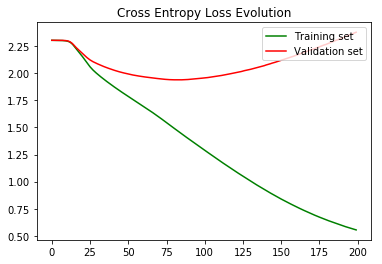

In [26]:
W1, b1, W2, b2 = initialize_weights(d=X_training_1.shape[0], m=50, K=Y_training_1.shape[0])
GD_params = [100, 0.05, 200]

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGD(   X_training[:, :1000],
                                                                        Y_training[:, :1000],
                                                                        X_validation[:, :1000],
                                                                        Y_validation[:, :1000],
                                                                        [], [],
                                                                        GD_params,
                                                                        W1, b1, W2, b2)

visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution')

We observe overfitting in the training data, as the loss on the training set gets pretty small values, while the loss on the validation set starts increasing after a few number of epochs. 

#### Exercise 3: Add momentum to your update step

In [34]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :2000],
                                                                                    Y_training[:, :2000],
                                                                                    X_validation[:, :2000],
                                                                                    Y_validation[:, :2000],
                                                                                    [], [],
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.99)

100%|██████████| 200/200 [00:20<00:00,  9.59it/s]


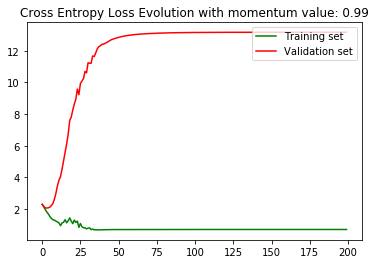

<Figure size 432x288 with 0 Axes>

In [37]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.99')

In [44]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :2000],
                                                                                    Y_training[:, :2000],
                                                                                    X_validation[:, :2000],
                                                                                    Y_validation[:, :2000],
                                                                                    [], [],
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.9)


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


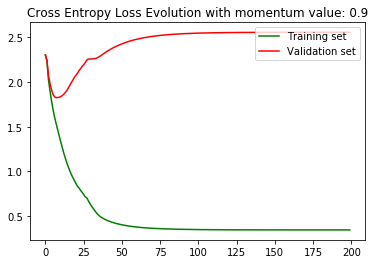

<Figure size 432x288 with 0 Axes>

In [45]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.9')

In [46]:
W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(   X_training[:, :500],
                                                                                    Y_training[:, :500],
                                                                                    X_validation[:, :500],
                                                                                    Y_validation[:, :500],
                                                                                    [], [],
                                                                                    GD_params,
                                                                                    W1, b1, W2, b2,
                                                                                    regularization_term=0,
                                                                                    momentum_term=0.)


100%|██████████| 200/200 [00:05<00:00, 36.37it/s]

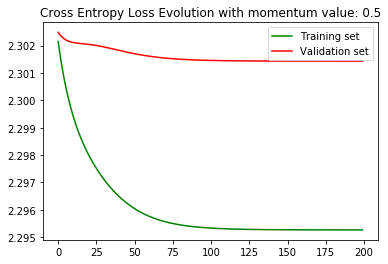

<Figure size 432x288 with 0 Axes>

In [47]:
visualize_costs(training_set_loss, validation_set_loss, display=True, title='Cross Entropy Loss Evolution with momentum value: 0.5', save_name='3_momentum_0-5', save_path='../figures')

#### Exercise 4: Training your network

In [31]:
    def random_search():
        """
        Random search to estimate the rough bounds for the values to eta to look for later in the coarse search.

        :return:
        """

        training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
        X_training, Y_training, y_training = training_data
        X_validation, Y_validation, y_validation = validation_data

        for eta in [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:

            print('-----------------------')
            print('eta: ', eta)

            GD_params = [100, eta, 5]

            W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                             Y_training,
                                                                                             X_validation,
                                                                                             Y_validation,
                                                                                             GD_params,
                                                                                             W1, b1, W2, b2,
                                                                                             regularization_term=0.000001,
                                                                                             momentum_term=0.9)

            W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

#             visualize_single_cost(training_set_loss, display=False, title='Training set loss evolution for eta: '+str(eta), save_name='Eta_random_'+str(eta).replace('.', '-'))

        for eta in np.arange(0.2, 0.5, 0.05):

            print('-----------------------')
            print('eta: ', eta)

            GD_params = [100, eta, 5]

            W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                             Y_training,
                                                                                             X_validation,
                                                                                             Y_validation,
                                                                                             GD_params,
                                                                                             W1, b1, W2, b2,
                                                                                             regularization_term=0.000001,
                                                                                             momentum_term=0.9)

            W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

#             visualize_single_cost(training_set_loss, display=False, title='Training set loss evolution for eta: '+str(eta), save_name='Eta_random_'+str(eta).replace('.', '-'))

In [32]:
random_search()

-----------------------
eta:  1e-05
Training set loss after epoch number 0 is: 2.3025848506920643
Training set loss after epoch number 1 is: 2.302583841443368
Training set loss after epoch number 2 is: 2.3025828840707727
Training set loss after epoch number 3 is: 2.3025819761862096
Training set loss after epoch number 4 is: 2.3025811148946467
-----------------------
eta:  5e-05
Training set loss after epoch number 0 is: 2.302581166802597
Training set loss after epoch number 1 is: 2.3025761599923698
Training set loss after epoch number 2 is: 2.3025714319240826
Training set loss after epoch number 3 is: 2.302566964345669
Training set loss after epoch number 4 is: 2.3025627410959992
-----------------------
eta:  0.0001
Training set loss after epoch number 0 is: 2.30257658291642
Training set loss after epoch number 1 is: 2.302566649200436
Training set loss after epoch number 2 is: 2.3025573099186
Training set loss after epoch number 3 is: 2.302548512635035
Training set loss after epoch num

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Training set loss after epoch number 0 is: inf
-----------------------
eta:  0.44999999999999996
Training set loss after epoch number 0 is: inf


In [38]:
def coarse_search(e_min= np.log(0.01), e_max=np.log(0.15)):
    """
    First step of coarse search, optimal value for the learning rate may be found between 0.01 and 0.15

    :return: Best pair of eta and lambda based on validation set accuracy performance
    """

    training_data, validation_data, test_data, W1, b1, W2, b2 = exercise_1()
    X_training, Y_training, y_training = training_data
    X_validation, Y_validation, y_validation = validation_data

    accuracies = []
    etas = []
    lambdas = []

    for regularization_term in [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 1e-1, 1]:

        for _ in range(12):
            np.random.seed()
            eta_term = np.random.rand(1, 1).flatten()[0]
            e = e_min + (e_max - e_min) * eta_term
            eta = np.exp(e)
            etas.append(eta)

            lambdas.append(regularization_term)

            GD_params = [100, eta, 10]

            W1, b1, W2, b2, training_set_loss, validation_set_loss = MiniBatchGDwithMomentum(X_training,
                                                                                             Y_training,
                                                                                             X_validation,
                                                                                             Y_validation,
                                                                                             GD_params,
                                                                                             W1, b1, W2, b2,
                                                                                             regularization_term=regularization_term)
            print('---------------------------------')
            print('Learning rate: '+str(eta)+', amount of regularization term: '+str(regularization_term))
            accuracy_on_validation_set = ComputeAccuracy(X_validation, y_validation, W1, b1, W2, b2)
            accuracies.append(accuracy_on_validation_set)
            print('Accuracy performance on the validation set: ', accuracy_on_validation_set)

            W1, b1, W2, b2 = initialize_weights(d=X_training.shape[0], m=50, K=Y_training.shape[0])

    sort_them_all = sorted(zip(accuracies, etas, lambdas))

    best_accuracies = [x for x, _ , _ in sort_them_all]
    best_etas = [y for _, y , _ in sort_them_all]
    best_lambdas = [z for _, _ , z in sort_them_all]

    print('---------------------------------')
    print('BEST PERFORMANCE: ', str(best_accuracies[-1]))
    print('Best eta: ', best_etas[-1])
    print('Best lambda: ', best_lambdas[-1])

    print('---------------------------------')
    print('SECOND BEST PERFORMANCE: ', str(best_accuracies[-2]))
    print('Second best eta: ', best_etas[-2])
    print('Second best lambda: ', best_lambdas[-2])

    print('---------------------------------')
    print('THIRD BEST PERFORMANCE: ', str(best_accuracies[-3]))
    print('Third best eta: ', best_etas[-3])
    print('Third best lambda: ', best_lambdas[-3])

In [ ]:
coarse_search()

---------------------------------
Learning rate: 0.01682656011091022, amount of regularization term: 0
Accuracy performance on the validation set:  42.83
